<a href="https://colab.research.google.com/github/tran-learner/GA_Server/blob/main/G%26A_Dectect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import zipfile
# from google.colab import drive

# drive.mount('/content/drive')

In [ ]:
import kagglehub
jangedoo_utkface_new_path = kagglehub.dataset_download('jangedoo/utkface-new')

print('Data source import complete.')
print(jangedoo_utkface_new_path)

100%|██████████| 331M/331M [00:03<00:00, 91.5MB/s]

Extracting files...


Data source import complete.
/root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1


In [ ]:
import os

# path = "/root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1"
# files = os.listdir(path)
# files

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
%matplotlib inline

import tensorflow as tf
# from tensorflow.keras.preprocessing.image import load_img
from keras._tf_keras.keras.preprocessing.image import load_img
from keras._tf_keras.keras.models import Sequential, Model
from keras._tf_keras.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, Input

In [ ]:
BASE_DIR = '/root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/UTKFace/'

In [ ]:
image_paths = []
age_labels = []
gender_labels = []
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp =  filename.split('_')
    image_paths.append(image_path)
    age_labels.append(int(temp[0]))
    gender_labels.append(int(temp[1]))


  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame()
df['image'] = image_paths
df['age'] = age_labels
df['gender'] = gender_labels
df.head()

,image,age,gender
0,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,2,0
1,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,53,1
2,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,30,1
3,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,54,0
4,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,1,0


In [ ]:
gender_dict = {0:'Male',1:'Female'}

Exploratory Data Analysis

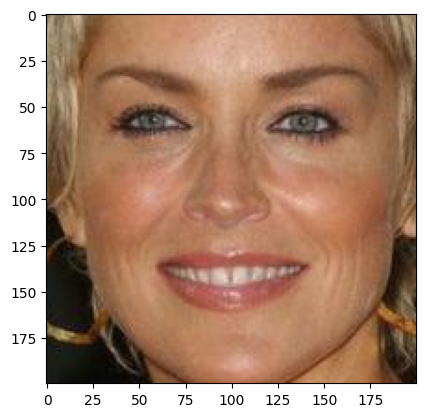

In [ ]:
from PIL import Image
img = Image.open(df['image'][1])
# plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Count'>

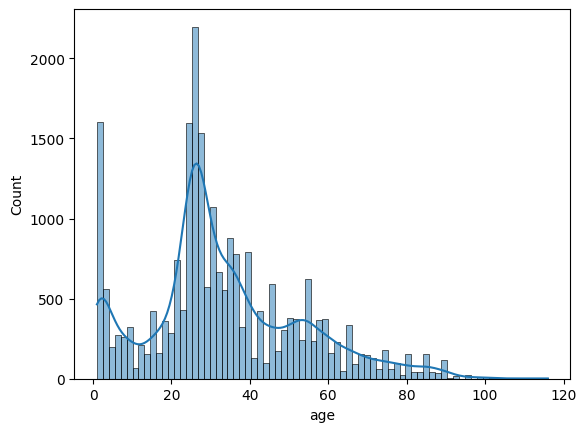

In [ ]:
sns.histplot(df['age'],kde=True)
# sns.kdeplot(df['age_label'])

In [ ]:
sns.countplot(x='gender',data=df)
# sns.histplot(df['gender'], kde=True)
# print(df['gender'])

In [ ]:
#display grid of images
plt.figure(figsize=(20,20))
files = df.iloc[0:20]

for index, img, age, gender in files.itertuples():
    plt.subplot(4,5, index+1)
    img = load_img(img)
    # img = Image.open(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [ ]:
## Feature extraction
def extract_features(images):
  features = []
  for image in tqdm(images):
    img = load_img(image, color_mode="grayscale")
    img = img.resize((128,128))
    img = np.array(img)
    features.append(img)
  features = np.array(features)
  features = features.reshape(len(features), 128, 128, 1)
  return features

In [ ]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
X = X/255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128,128,1)

Model Creation

In [ ]:
inputs = Input((input_shape))
#convolutional layers
conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)


flatten = Flatten()(maxp_4)

In [ ]:
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

In [ ]:
model = Model(inputs=inputs, outputs=[output_1, output_2])
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy','mae'])

In [ ]:
model.summary()

In [ ]:
# from tensorflow.keras.utils import plot_model
from keras.utils import plot_model
# plot_model(model)

In [ ]:
#train
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

In [ ]:
acc = history.history['gender_output_accuracy']
val_acc = history.history['val_gender_output_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy graph')
plt.legend()
plt.figure()

gender_loss = history.history['gender_output_loss']
val_loss = history.history['val_gender_output_loss']
plt.plot(epochs, gender_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss graph')
plt.legend()
plt.show()



In [ ]:
age_loss = history.history['age_output_loss']
age_val_loss = history.history['val_age_output_loss']
epochs = range(len(acc))
plt.plot(epochs, age_loss, 'b', label='Training loss')
plt.plot(epochs, age_val_loss, 'r', label='Validation loss')
plt.title('Age Loss graph')
plt.legend()
plt.show()

Predict with image

In [ ]:
image_index = 125
print("Gender is ", gender_dict[y_gender[image_index]])
print("Age: ", y_age[image_index])

plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray')
#predict from model
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender is ", pred_gender)
print("Predicted Age is ", pred_age)

Save model

In [ ]:
# # model.save('ga_model.h5')
# from google.colab import files
# # files.download('ga_model.h5')

# import joblib
# joblib.dump(model, 'ga_model.pkl')
# files.download('ga_model.pkl')

In [ ]:
model.summary()

In [ ]:
# from google.colab import files
# uploaded = files.upload()


In [ ]:
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# image_path = '/content/RM-profile1.jpg'
# imagev = load_img(image_path, target_size=(128, 128), color_mode="grayscale")
# imagev = img_to_array(imagev)
# imagev = imagev.reshape(1, 128, 128, 1)
# imagev = imagev / 255.0
# pred = model.predict(imagev)
# print(pred)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Giả sử imagev là ảnh đã xử lý (shape: (128, 128, 1))
# plt.imshow(imagev.squeeze(), cmap='gray')  # squeeze() để loại bỏ chiều dư
# plt.title("Processed Image")
# plt.axis("off")
# plt.show()


In [ ]:
# print(imagev.shape)
